In [4]:
import numpy as np
import math
from datascience import *
import pandas as pd
import matplotlib
import json
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
twitter_data_df = pd.read_csv('twcs.csv')

In [8]:
twitter_data_df

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,NaN,12.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,@115713 We understand your concerns and we'd l...,12,16.0


In [113]:
#!/usr/bin/env python

# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Google Cloud Speech API sample application using the streaming API.
NOTE: This module requires the additional dependency `pyaudio`. To install
using pip:
    pip install pyaudio
Example usage:
    python transcribe_streaming_mic.py
"""

# [START speech_transcribe_streaming_mic]
from __future__ import division

import re
import sys

from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types
import pyaudio
from six.moves import queue

# Audio recording parameters
RATE = 16000
CHUNK = int(RATE / 10)  # 100ms


class MicrophoneStream(object):
    """Opens a recording stream as a generator yielding the audio chunks."""
    def __init__(self, rate, chunk):
        self._rate = rate
        self._chunk = chunk

        # Create a thread-safe buffer of audio data
        self._buff = queue.Queue()
        self.closed = True

    def __enter__(self):
        self._audio_interface = pyaudio.PyAudio()
        self._audio_stream = self._audio_interface.open(
            format=pyaudio.paInt16,
            # The API currently only supports 1-channel (mono) audio
            # https://goo.gl/z757pE
            channels=1, rate=self._rate,
            input=True, frames_per_buffer=self._chunk,
            # Run the audio stream asynchronously to fill the buffer object.
            # This is necessary so that the input device's buffer doesn't
            # overflow while the calling thread makes network requests, etc.
            stream_callback=self._fill_buffer,
        )

        self.closed = False

        return self

    def __exit__(self, type, value, traceback):
        self._audio_stream.stop_stream()
        self._audio_stream.close()
        self.closed = True
        # Signal the generator to terminate so that the client's
        # streaming_recognize method will not block the process termination.
        self._buff.put(None)
        self._audio_interface.terminate()

    def _fill_buffer(self, in_data, frame_count, time_info, status_flags):
        """Continuously collect data from the audio stream, into the buffer."""
        self._buff.put(in_data)
        return None, pyaudio.paContinue

    def generator(self):
        while not self.closed:
            # Use a blocking get() to ensure there's at least one chunk of
            # data, and stop iteration if the chunk is None, indicating the
            # end of the audio stream.
            chunk = self._buff.get()
            if chunk is None:
                return
            data = [chunk]

            # Now consume whatever other data's still buffered.
            while True:
                try:
                    chunk = self._buff.get(block=False)
                    if chunk is None:
                        return
                    data.append(chunk)
                except queue.Empty:
                    break

            yield b''.join(data)

transcript_list = []
def listen_print_loop(responses):
    """Iterates through server responses and prints them.
    The responses passed is a generator that will block until a response
    is provided by the server.
    Each response may contain multiple results, and each result may contain
    multiple alternatives; for details, see https://goo.gl/tjCPAU.  Here we
    print only the transcription for the top alternative of the top result.
    In this case, responses are provided for interim results as well. If the
    response is an interim one, print a line feed at the end of it, to allow
    the next result to overwrite it, until the response is a final one. For the
    final one, print a newline to preserve the finalized transcription.
    """
    num_chars_printed = 0
    for response in responses:
        if not response.results:
            continue

        # The `results` list is consecutive. For streaming, we only care about
        # the first result being considered, since once it's `is_final`, it
        # moves on to considering the next utterance.
        result = response.results[0]
        if not result.alternatives:
            continue

        # Display the transcription of the top alternative.
        transcript = result.alternatives[0].transcript
        
        # Display interim results, but with a carriage return at the end of the
        # line, so subsequent lines will overwrite them.
        #
        # If the previous result was longer than this one, we need to print
        # some extra spaces to overwrite the previous result
        overwrite_chars = ' ' * (num_chars_printed - len(transcript))

        if not result.is_final:
            sys.stdout.write(transcript + overwrite_chars + '\r')
            sys.stdout.flush()

            num_chars_printed = len(transcript)

        else:
            print(transcript + overwrite_chars)
            transcript_list.append(transcript + overwrite_chars)
            # Exit recognition if any of the transcribed phrases could be
            # one of our keywords.
            if re.search(r'\b(exit|quit|goodbye)\b', transcript, re.I):
                print('Exiting..')
                break

            num_chars_printed = 0


def main():
    # See http://g.co/cloud/speech/docs/languages
    # for a list of supported languages.
    language_code = 'en-US'  # a BCP-47 language tag

    client = speech.SpeechClient()
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=RATE,
        language_code=language_code)
    streaming_config = types.StreamingRecognitionConfig(
        config=config,
        interim_results=True)

    with MicrophoneStream(RATE, CHUNK) as stream:
        audio_generator = stream.generator()
        requests = (types.StreamingRecognizeRequest(audio_content=content)
                    for content in audio_generator)

        responses = client.streaming_recognize(streaming_config, requests)

        # Now, put the transcription responses to use.
        listen_print_loop(responses)


if __name__ == '__main__':
    main()
# [END speech_transcribe_streaming_mic]

to whom it may concern I'm looking to get help with your product or service
 goodbye
Exiting..


In [120]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/wyattowalsh/Desktop/SacHacks2018-87e63fa0cf3e.json"
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

# Instantiates a client
client = language.LanguageServiceClient()

# The text to analyze
tot_text = transcript_list[0]
tot_document = types.Document(
    content=tot_text,
    type=enums.Document.Type.PLAIN_TEXT)
# Detects the sentiment of the text

sentiment = client.analyze_sentiment(document=tot_document).document_sentiment
"""sentiment_score_collection = []
sentiment_mag_collection = []
for company in company_convos:
    for customer in company_convos[company]:
        for sentence in company_convos[company][customer]:
            text = sentence
            document = types.Document(
                content = text,
                type=enums.Document.Type.PLAIN_TEXT)
            sentiment_score_collection = np.append(sentiment_score_collection,client.analyze_sentiment(document=document).document_sentiment.score )
            sentiment_mag_collection = np.append(sentiment_mag_collection,client.analyze_sentiment(document=document).document_sentiment.magnitude )
"""


print('Text: {}'.format(tot_text))
print('Sentiment: {}, {}'.format(sentiment.score, sentiment.magnitude))


ResourceExhausted: 429 Quota exceeded for quota metric 'language.googleapis.com/default_requests' and limit 'DefaultRequestsPerMinutePerProject' of service 'language.googleapis.com' for consumer 'project_number:713720177927'.

In [115]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/wyattowalsh/Desktop/SacHacks2018-87e63fa0cf3e.json"
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

# Instantiates a client
client = language.LanguageServiceClient()

# The text to analyze
tot_text = ' '.join(company_convos_no_at['sprintcare']['115712'][0:])
tot_document = types.Document(
    content=tot_text,
    type=enums.Document.Type.PLAIN_TEXT)
# Detects the sentiment of the text

sentiment = client.analyze_sentiment(document=tot_document).document_sentiment
sentiment_score_collection = []
sentiment_mag_collection = []
for company in company_convos:
    for customer in company_convos[company]:
        for sentence in company_convos[company][customer]:
            text = sentence
            document = types.Document(
                content = text,
                type=enums.Document.Type.PLAIN_TEXT)
            sentiment_score_collection = np.append(sentiment_score_collection,client.analyze_sentiment(document=document).document_sentiment.score )
            sentiment_mag_collection = np.append(sentiment_mag_collection,client.analyze_sentiment(document=document).document_sentiment.magnitude )



print('Text: {}'.format(tot_text))
print('Sentiment: {}, {}'.format(sentiment.score, sentiment.magnitude))
sentiment_score_collection, sentiment_mag_collection

KeyboardInterrupt: 

Exception ignored in: 'grpc._cython.cygrpc.ReceiveInitialMetadataOperation.un_c'
Traceback (most recent call last):
  File "src/python/grpcio/grpc/_cython/_cygrpc/metadata.pyx.pxi", line 58, in grpc._cython.cygrpc._metadata
  File "src/python/grpcio/grpc/_cython/_cygrpc/metadata.pyx.pxi", line 59, in genexpr
  File "src/python/grpcio/grpc/_cython/_cygrpc/metadata.pyx.pxi", line 53, in grpc._cython.cygrpc._metadatum
  File "<string>", line 12, in __new__
KeyboardInterrupt


ResourceExhausted: 429 Quota exceeded for quota metric 'language.googleapis.com/default_requests' and limit 'DefaultRequestsPerMinutePerProject' of service 'language.googleapis.com' for consumer 'project_number:713720177927'.

In [32]:
company_convos = {}
company_convos_no_at = {}
count = 0;
for rows in twitter_data_df.iterrows():
    #flag = false # false if customer, true if company
    
    # ignore messages without @ for now...
    if rows[1][4][0] != "@":
        continue
    # takes too long to load everything 
    count += 1
    if count > 500:
        break
    try: 
        # if message from customer
        #print("customer: ", str(int(rows[1][1])))
        cust_id = str(int(rows[1][1]))
        index = -1 # index of space for company name
        for i in range(len(rows[1][4])):
            if rows[1][4][i] == " ":
                index = i
                #print(index)
                break
        company_name = rows[1][4][1:index] 
        #print(company_name)
        #break
    except: 
        # if message from company
        #flag = true
        company_name = rows[1][1]
        cust_id = str(rows[1][4][1:7])
        index = 7
        
    if company_name in company_convos:
        customer_dict = company_convos.get(company_name)
        customer_dict_no_at = company_convos_no_at.get(company_name)
        
        
        if cust_id in customer_dict:
            customer_dict[cust_id].append(rows[1][4])   
            
        else:
            customer_dict[cust_id] = [rows[1][4]] 
            
            
        if cust_id in customer_dict_no_at:
            customer_dict_no_at[cust_id].append(rows[1][4][index:])   
        else:
            customer_dict_no_at[cust_id] = [rows[1][4][index:]] 
            
    else:
        company_convos[company_name] = {}
        company_convos[company_name][cust_id] = [rows[1][4][index:]] 
        
        company_convos_no_at[company_name] = {}
        company_convos_no_at[company_name][cust_id] = [rows[1][4][index:]] 
        
        
    
            
    

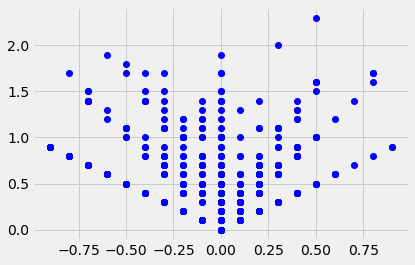

In [75]:
#Table().with_columns('Score',sentiment_score_collection,'Magnitude', sentiment_mag_collection).scatter('Score')
for i in range(len(sentiment_score_collection)):
    x = sentiment_score_collection[i]
    y = sentiment_mag_collection[i]
    plots.plot(x, y, 'bo')

In [109]:
transcript_list

['hello this is a test',
 " I'm hoping to determine if this works",
 ' I like apples',
 ' bananas are cool to only sometimes',
 ' goodbye']